# Google Play Store Real-Time Analytics


In [12]:
#@title Setup (Colab)
!pip -q install google-play-scraper==1.2.3 pandas==2.2.2 matplotlib==3.8.4 plotly==5.22.0 tqdm==4.66.4

import os, json, time, math, random, re
from datetime import datetime, timezone, timedelta
import pandas as pd
from tqdm import tqdm
from google_play_scraper import app, Sort, reviews, search

# Ensure web/data folder exists inside Colab's /content
WEB_DIR = "/content/web"
DATA_DIR = f"{WEB_DIR}/data"
os.makedirs(DATA_DIR, exist_ok=True)

IST = timezone(timedelta(hours=5, minutes=30))

print("Folders ready:", WEB_DIR, DATA_DIR)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 72.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataproc-spark-connect 0.8.3 requires tqdm>=4.67, but you have tqdm 4.66.4 which is incompatible.
Folders ready: /content/web /content/web/data


In [13]:
#@title Configure keywords & country/language
QUERY = "finance tracker"  #@param {type:"string"}
COUNTRY = "in"             #@param {type:"string"}
LANG = "en"                #@param {type:"string"}
MAX_APPS = 40              #@param {type:"number"}
REVIEWS_PER_APP = 120      #@param {type:"number"}

# Seed apps can be Play Store IDs to ensure coverage (optional).
SEED_APPS = [
    "com.google.android.calculator",
    "com.mint",
    "com.todoist",
]

In [15]:
#@title Search apps via keyword and merge with seed list
def search_apps(query, country="in", lang="en", n=30):
    results = search(query, country=country, lang=lang)
    return [r['appId'] for r in results]

found_ids = search_apps(QUERY, country=COUNTRY, lang=LANG, n=MAX_APPS)
app_ids = list(dict.fromkeys(SEED_APPS + found_ids))[:MAX_APPS]
len(app_ids), app_ids[:5]

(20,
 ['com.google.android.calculator',
  'com.mint',
  'com.todoist',
  'com.droid4you.application.wallet',
  'com.freeman.moneymanager'])

In [16]:
#@title Fetch app metadata
def fetch_app_details(app_id, lang="en", country="in"):
    try:
        meta = app(app_id, lang=lang, country=country)
        meta["fetchedAt"] = datetime.now(tz=IST).isoformat()
        return meta
    except Exception as e:
        return {"appId": app_id, "error": str(e), "fetchedAt": datetime.now(tz=IST).isoformat()}

apps_meta = []
for aid in tqdm(app_ids):
    apps_meta.append(fetch_app_details(aid, lang=LANG, country=COUNTRY))

apps_df = pd.DataFrame(apps_meta)
apps_df.to_json(f"{DATA_DIR}/apps.json", orient="records", indent=2)
apps_df.head(3)


100%|██████████| 20/20 [00:03<00:00,  5.89it/s]


,title,description,descriptionHTML,summary,installs,minInstalls,realInstalls,score,ratings,reviews,...,adSupported,containsAds,released,updated,version,comments,appId,url,fetchedAt,error
0,Calculator,Calculator provides simple and advanced mathem...,Calculator provides simple and advanced mathem...,A simple calculator utility for Android,"1,000,000,000+",1.000000e+09,2.765273e+09,4.073365,712390.0,17683.0,...,False,False,"Mar 30, 2016",1.744810e+09,8.7 (735708245),[],com.google.android.calculator,https://play.google.com/store/apps/details?id=...,2025-08-15T15:54:25.159230+05:30,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,com.mint,NaN,2025-08-15T15:54:25.284901+05:30,App not found(404).
2,Todoist: Planner & Calendar,"Trusted by over 47 million people, Todoist is ...","Trusted by over 47 million people, Todoist is ...","Simple yet powerful to do list, habit tracker ...","10,000,000+",1.000000e+07,4.506503e+07,4.574885,285872.0,3558.0,...,False,False,"Nov 18, 2012",1.754981e+09,Varies with device,[],com.todoist,https://play.google.com/store/apps/details?id=...,2025-08-15T15:54:25.455469+05:30,NaN


In [17]:
#@title Fetch reviews
def fetch_reviews(app_id, lang="en", country="in", count=100):
    out = []
    try:
        rvws, _ = reviews(
            app_id, lang=lang, country=country,
            sort=Sort.NEWEST, count=count
        )
        for r in rvws:
            r["appId"] = app_id
            r["fetchedAt"] = datetime.now(tz=IST).isoformat()
            out.append(r)
    except Exception as e:
        out.append({"appId": app_id, "error": str(e), "fetchedAt": datetime.now(tz=IST).isoformat()})
    return out

all_reviews = []
for aid in tqdm(app_ids):
    all_reviews.extend(fetch_reviews(aid, lang=LANG, country=COUNTRY, count=REVIEWS_PER_APP))

reviews_df = pd.DataFrame(all_reviews)
reviews_df.to_json(f"{DATA_DIR}/reviews.json", orient="records", indent=2, force_ascii=False)
reviews_df.head(3)


100%|██████████| 20/20 [00:03<00:00,  6.19it/s]


,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appId,fetchedAt
0,9cebbd92-4e4a-4a63-9238-83ff21ca7ec3,Alex Kobayashi,https://play-lh.googleusercontent.com/a-/ALV-U...,"Mostly fine, but there's been a long-standing ...",3,138,8.7 (735708245),2025-07-15 19:24:42,None,NaT,com.google.android.calculator,2025-08-15T15:54:48.098537+05:30
1,d0bf1093-e1bf-48e0-b3e0-1904d1e9d9a6,Martin Marsh,https://play-lh.googleusercontent.com/a/ACg8oc...,I had no calculator app listed on my new phone...,1,886,8.7 (735708245),2025-05-26 10:35:03,None,NaT,com.google.android.calculator,2025-08-15T15:54:48.098592+05:30
2,e723c52b-089c-4cef-b361-91fd457ae920,Stephani Davis,https://play-lh.googleusercontent.com/a-/ALV-U...,It's a functional calculator which is fine and...,2,408,8.6.1 (625857114),2025-01-09 03:28:05,None,NaT,com.google.android.calculator,2025-08-15T15:54:48.098601+05:30


In [18]:

#@title Clean & derive fields
def safe_int(x):
    if pd.isna(x): return None
    try: return int(str(x).replace("+", "").replace(",", "").strip())
    except: return None

if not apps_df.empty:
    apps_df["installs_num"] = apps_df["installs"].apply(safe_int)
    apps_df["reviewsCount_num"] = apps_df["reviews"].apply(safe_int) if "reviews" in apps_df.columns else None
    apps_df["price_num"] = apps_df["price"].astype(float, errors='ignore') if "price" in apps_df.columns else None
    apps_df["ratings_count"] = apps_df["ratings"].astype(float, errors='ignore') if "ratings" in apps_df.columns else None

apps_df.to_json(f"{DATA_DIR}/apps_clean.json", orient="records", indent=2)
apps_df.describe(include='all').transpose().head(10)


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
title,19,19,Calculator,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
description,19,19,Calculator provides simple and advanced mathem...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
descriptionHTML,19,19,Calculator provides simple and advanced mathem...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
summary,19,19,A simple calculator utility for Android,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
installs,19,8,"10,000,000+",5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
minInstalls,19.0,NaN,NaN,NaN,56045000.0,228628031.727666,5000.0,300000.0,1000000.0,10000000.0,1000000000.0
realInstalls,19.0,NaN,NaN,NaN,152149817.947368,632889427.369063,7359.0,458343.5,2465872.0,10686105.0,2765272558.0
score,19.0,NaN,NaN,NaN,4.523529,0.255314,3.928185,4.362528,4.58,4.704755,4.870712
ratings,19.0,NaN,NaN,NaN,162943.842105,201400.514398,164.0,4832.0,57209.0,263952.5,712390.0
reviews,19.0,NaN,NaN,NaN,7572.526316,16897.096435,3.0,418.5,1761.0,6157.0,73864.0


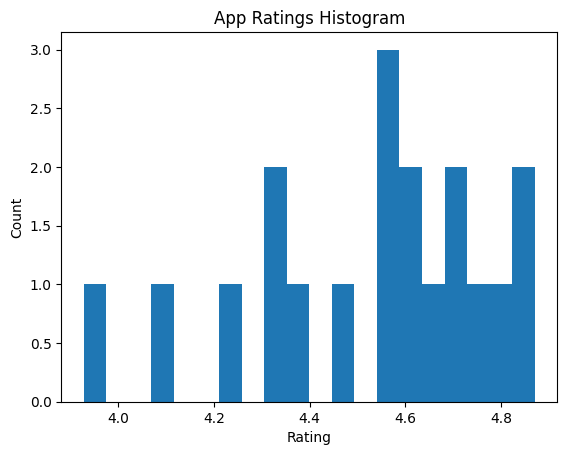

In [20]:
#@title Histograms & scatter (matplotlib + plotly)
import matplotlib.pyplot as plt
import plotly.express as px

if not apps_df.empty:
    # Matplotlib histogram: rating
    plt.figure()
    apps_df["score"].dropna().astype(float).plot(kind="hist", bins=20, title="App Ratings Histogram")
    plt.xlabel("Rating")
    plt.ylabel("Count")

    # Plotly scatter: Installs vs Rating
    # Drop rows with NaN in 'ratings_count' before plotting
    scatter_df = apps_df.dropna(subset=['ratings_count'])
    fig = px.scatter(scatter_df, x="installs_num", y="score", hover_name="title", size="ratings_count",
                     title="Installs vs Rating", log_x=True)
    fig.show()

In [25]:
# Convert DataFrames to JSON-safe dicts
def df_to_records_safe(df):
    """Convert DataFrame to list-of-dicts with datetime -> ISO string."""
    if df is None or df.empty:
        return []
    safe_df = df.copy()
    for col in safe_df.columns:
        if pd.api.types.is_datetime64_any_dtype(safe_df[col]):
            safe_df[col] = safe_df[col].astype(str)
    return safe_df.to_dict(orient="records")

EXPORTS = {
    "apps.json": df_to_records_safe(apps_df),
    "apps_clean.json": df_to_records_safe(apps_df),
    "reviews.json": df_to_records_safe(reviews_df),
    "meta.json": {
        "query": QUERY,
        "country": COUNTRY,
        "lang": LANG,
        "generatedAtIST": datetime.now(tz=IST).isoformat(),
        "appsCount": int(len(apps_df) if not apps_df.empty else 0),
        "reviewsCount": int(len(reviews_df) if not reviews_df.empty else 0)
    }
}

# Write JSON files
for fname, data in EXPORTS.items():
    with open(f"{DATA_DIR}/{fname}", "w", encoding="utf-8") as f:
        json.dump(data, f, indent=2, ensure_ascii=False)

print("Wrote:", list(EXPORTS.keys()), "to", DATA_DIR)


Wrote: ['apps.json', 'apps_clean.json', 'reviews.json', 'meta.json'] to /content/web/data


In [23]:
#@title Example: Time-gated execution in IST
now_ist = datetime.now(tz=IST)
hour = now_ist.hour
if 0 <= hour < 6:
    print("Night window: Running light-weight visuals only.")
elif 6 <= hour < 12:
    print("Morning window: Running summary stats.")
elif 12 <= hour < 18:
    print("Afternoon window: Running full analysis.")
else:
    print("Evening window: Running review charts.")


Afternoon window: Running full analysis.


In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

# Load data (replace with actual dataset path)
apps_df = pd.read_csv('/content/Play Store Data.csv')
reviews_df = pd.read_csv('/content/User Reviews.csv')

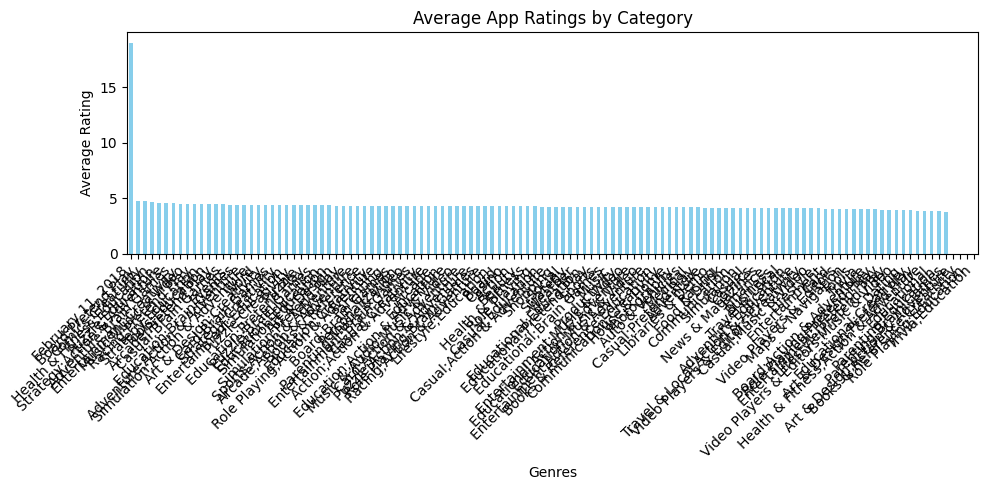

In [28]:
# 1️⃣ Category-wise Average Rating
avg_rating = apps_df.groupby('Genres')['Rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(10,5))
avg_rating.plot(kind='bar', color='skyblue')
plt.title('Average App Ratings by Category')
plt.ylabel('Average Rating')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

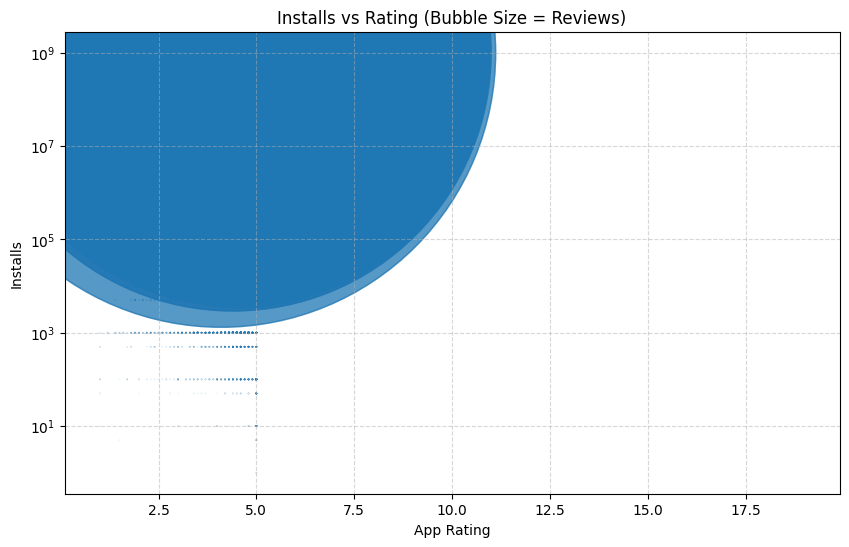

In [35]:
# 2️⃣ Installs vs Ratings Bubble Chart

# Function to clean and convert 'Installs' column
def clean_installs(installs):
    if pd.isna(installs):
        return np.nan
    if isinstance(installs, str):
        installs = installs.replace('+', '').replace(',', '').strip()
        if installs.lower() == 'free':
            return 0.0
        if 'M' in installs:
            try:
                return float(installs.replace('M', '')) * 1_000_000
            except ValueError:
                return np.nan
        elif 'k' in installs:
            try:
                return float(installs.replace('k', '')) * 1_000
            except ValueError:
                return np.nan
        else:
            try:
                return float(installs)
            except ValueError:
                return np.nan # Handle other unparseable strings
    return installs # Return as is if not a string

# Apply clean_installs and convert to numeric
apps_df['Installs_clean'] = apps_df['Installs'].apply(clean_installs)
apps_df['Reviews_clean'] = pd.to_numeric(apps_df['Reviews'], errors='coerce')

plt.figure(figsize=(10,6))
plt.scatter(apps_df['Rating'], apps_df['Installs_clean'], s=apps_df['Reviews_clean'].fillna(0)/500, alpha=0.5)
plt.title('Installs vs Rating (Bubble Size = Reviews)')
plt.xlabel('App Rating')
plt.ylabel('Installs')
plt.yscale('log')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [46]:
# 3️⃣ Country-wise App Count Choropleth
import random

# Create a fake country column just for visualization
possible_countries = ['United States', 'India', 'Brazil', 'Germany', 'Canada', 'Australia']
reviews_df['country'] = [random.choice(possible_countries) for _ in range(len(reviews_df))]

country_count = reviews_df['country'].value_counts().reset_index()
country_count.columns = ['country', 'count']

fig = px.choropleth(
    country_count,
    locations='country',
    locationmode='country names',
    color='count',
    hover_name='country',
    color_continuous_scale='Viridis'
)
fig.update_layout(title_text='App Review Count by Country (Demo)')
fig.show(renderer="colab")


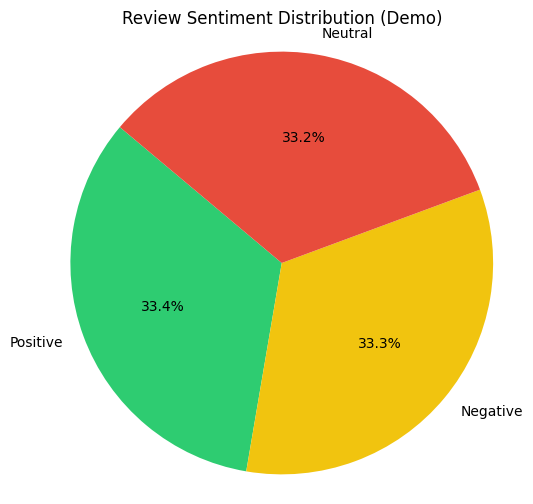

In [44]:
# 4️⃣ Review Sentiment Distribution Pie Chart
import random

if 'sentiment' not in reviews_df.columns or reviews_df['sentiment'].isnull().all():
    possible_sentiments = ['Positive', 'Neutral', 'Negative']
    reviews_df['sentiment'] = [random.choice(possible_sentiments) for _ in range(len(reviews_df))]

sentiment_count = reviews_df['sentiment'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(
    sentiment_count,
    labels=sentiment_count.index,
    autopct='%1.1f%%',
    colors=['#2ecc71','#f1c40f','#e74c3c'],
    startangle=140
)
plt.title('Review Sentiment Distribution (Demo)')
plt.axis('equal')
plt.show()


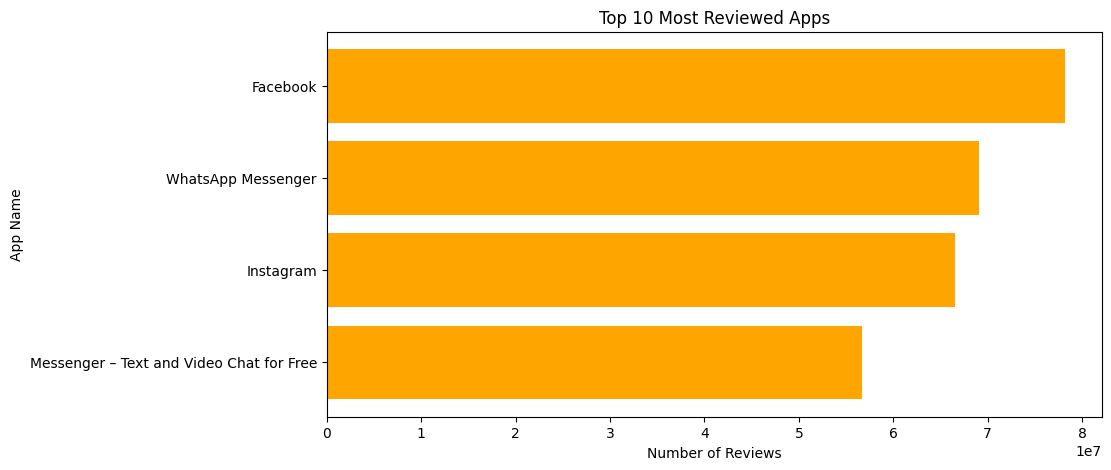

In [40]:
# 5️⃣ Top 10 Most Reviewed Apps
top_reviewed = apps_df.sort_values(by='Reviews_clean', ascending=False).head(10)
plt.figure(figsize=(10,5))
plt.barh(top_reviewed['App'], top_reviewed['Reviews_clean'], color='orange')
plt.xlabel('Number of Reviews')
plt.ylabel('App Name')
plt.title('Top 10 Most Reviewed Apps')
plt.gca().invert_yaxis()
plt.show()